## learning-AI : test various split method and application for making recurrent data
### 순환 데이터를 만들기 위한 split_sequence의 다양한 variation 및 그에 관한 테스트

<br>

- **임규연 (lky473736)**
- 2024.09.20. ~ 2024.09.21.에 문서 작성
- 예시 데이터셋은 현재 진행 중인 프로젝트인 **operation (https://github.com/lky473736/operation)** 에서 나온 아이디어를 가지고 만들었습니다.

------

- **Reference**
    - https://github.com/lky473736/learning-AI101/blob/main/insight/insight_3_split_sequence_and_CNN.ipynb
    - https://velog.io/@tobigsts1617/CNN-for-univariatemultivariatemulti-stepmultivariate-multi-step-TSF
    - https://qna.programmers.co.kr/questions/14992/%ED%8C%8C%EC%9D%B4%EC%8D%AC-lstm-%EC%8B%9C%EA%B3%84%EC%97%B4-%EC%98%88%EC%B8%A1-%ED%95%B4%EB%B4%A4%EB%8A%94%EB%8D%B0-%EC%A0%9C%EA%B0%80-%EC%9D%B4%ED%95%B4%ED%95%9C-%EA%B2%83%EC%9D%B4-%EB%A7%9E%EB%82%98%EC%9A%94
    - https://machinelearningmastery.com/
    


In [18]:
import os
import matplotlib.pyplot as plt
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.layers import Dense, Dropout, Reshape, Conv1D, BatchNormalization, Activation, AveragePooling1D, GlobalAveragePooling1D, Lambda, Input, Concatenate, Add, UpSampling1D, Multiply
from keras.models import Model
# objectives 작동 X -> losses로 변경
from keras.losses import mean_squared_error
from keras import backend as K
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau,LearningRateScheduler
from keras.initializers import random_normal
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import Callback

from sklearn.metrics import cohen_kappa_score, f1_score
from sklearn.model_selection import KFold, train_test_split

import random

----

### 도입 : 순환 데이터의 이해와 예시 데이터 만들기

이 방식은 각 데이터를 독립적으로 처리하므로 입력 데이터와 타깃 데이터를 분리하여 학습하는데, 이 방법은 각 데이터 포인트가 서로 연관이 없다고 가정합니다. 하지만 CNN, RNN, LSTM, U-Net, ResNet 같은 다양한 신경망 구조를 사용하면, 단순히 Dense Layer로 구성된 모델보다 훨씬 더 복잡하고 효율적인 학습이 가능하며, 더 빠르게 학습할 수 있습니다.

하지만, 단순히 입력 데이터(X_train)와 타깃 데이터(y_train)를 기존 방식처럼 독립적으로 잘라서 학습시키면, 결국에는 DNN처럼 각 데이터가 독립적으로 학습되는 구조가 되어버립니다. **기존과 동일한 방식대로 split하면 DNN과 결국 똑같은 원리로 학습을 진행하는 것과 마찬가지입니다.** 이를 방지하기 위해 '순환 데이터'를 사용하여, 데이터가 순차적이거나 서로 관련이 있는 경우에는 앞서 학습한 데이터를 반영하는 학습 구조를 설계할 수 있습니다.

예시를 들어보면, 만약 아래와 같은 데이터프레임이 있다고 가정합니다. 

| No  | feature1 | feature2 | feature3 | target |
|-----|----------|----------|----------|--------|
| 1   | 1.2      | 4.5      | 2.1      | 1      |
| 2   | 2.3      | 5.6      | 3.2      | 1      |
| 3   | 3.4      | 6.7      | 4.3      | 0      |
| 4   | 4.5      | 7.8      | 5.4      | 0      |
| 5   | 5.6      | 8.9      | 6.5      | 1      |
| 6   | 6.7      | 9.0      | 7.6      | 0      |
| 7   | 7.8      | 10.1     | 8.7      | 1      |
| 8   | 8.9      | 11.2     | 9.8      | 0      |
| 9   | 9.0      | 12.3     | 10.9     | 1      |
| 10  | 10.1     | 13.4     | 11.0     | 0      |

기존의 방식대로라면, 우리는 데이터를 다음과 같이 분리하여 학습에 사용할 것입니다. (라이브러리를 import하는 과정은 생략합니다.)

```python
df_input = df.drop('target', axis=1)  # feature1, feature2, feature3 열만 포함
df_target = df['target']  # target 열만 포함
X_train, X_test, y_train, y_test = train_test_split(df_input, df_target, test_size=0.1)
```


이러면 당연하게도, X_train과 y_train은 test_size를 고려하여 총 9개의 record를 가질 것이며 (왜냐면 저 데이터프레임의 열의 갯수 (record의 갯수)가 10개니깐), 각각의 record는 독립적으로 존재할 것입니다. 추후 modeling, compile 후 ```model.fit(X_train, y_train)```을 하게 되었을 땐, 각 record가 독립적으로 모델에 들어가서 차례대로 하나씩 학습을 진행할 것입니다. (물론 미니배치 경사 하강법을 이용하여 학습하지만, 결국엔 record가 독립적으로 대입되는 것이 맞습니다.) 예를 들어, 모델이 학습할 때 3번째 레코드(3.4, 6.7, 4.3)가 들어가면, 이 데이터는 1번째와 2번째 데이터를 고려하지 않고, 단독으로 학습된다는 것입니다. 결과적으로 DNN처럼 각 데이터가 독립적으로 학습되는 구조가 됩니다.

순환 데이터는 각 레코드를 독립적으로 학습하는 것이 아니라, 앞선 데이터를 함께 고려하여 학습하는 것이 목적입니다. 예를 들어, 모델이 3번째 레코드를 학습할 때, 1번째와 2번째 레코드까지 반영하여 학습한다면, 보다 유기적인 학습이 가능합니다. 이렇게 하면 단순한 레코드 학습을 넘어서 여러 레코드를 한 번에 학습할 수 있게 됩니다.

예를 들어, 위 df를 보았을 때 X_train을 다음과 같이 구성할 수 있습니다.

| No  | feature1 | feature2 | feature3 |
|-----|----------|----------|----------|
| 1   | 1.2      | 4.5      | 2.1      |
| 2   | 2.3      | 5.6      | 3.2      |
| 3   | 3.4      | 6.7      | 4.3      |

(이어서는 2, 3, 4 record를 한 입력, 3, 4, 5 record ...)

위와 같은 데이터를 모델의 입력으로 사용할 수 있습니다. 여기서 중요한 것은, **이 3개의 레코드를 하나의 데이터로 보고, 그에 따라 학습한다는 점**입니다. 

그러면 target 데이터는 어떻게 구성해야 할까요? 마지막 record의 target인 0으로 두어야 할까요? 아니면 위 3개의 record의 target인 1, 1, 0 중 빈도 수가 높은 1로 두어야 할까요? 이를 구성하기 위한 방법은 데이터의 유형에 따라 다르고, 이 문제가 classification인지, regression인지, clustering인지에 따라서 구분이 됩니다. 순환 데이터를 만드는 방법은 데이터의 유형에 따라, 데이터셋의 특성에 맞게끔 메소드를 구성하는 것이 매우 중요할 것입니다. 하지만 정형적으로 아래와 같은 방법으로 target을 구성합니다.

#### 1. Classification 문제의 타깃 구성 방법

1. **특정 window의 타깃 값 중 빈도가 가장 높은 클래스 선택**
   - 위 record 1, 2 ,3의 target값은 `1, 1, 0`입니다. 여기서 가장 많이 등장한 클래스인 `1`을 선택합니다.
   
2. **특정 window에서 마지막 레코드의 타깃 값을 선택**
   - 위의 예시에서는, 마지막 레코드의 타깃이 `0`이므로 이를 타깃 값으로 사용합니다.

3. **특정 window에서 특정 클래스의 존재 여부를 기반으로 타깃을 결정**
   - window 안에 `0`이라는 값이 있는지 여부에 따라 타깃을 `True` 또는 `False`로 정할 수 있습니다.
   - target 중 0이 있으므로, 이 target은 True입니다.

#### 2. Regression 문제의 타깃 구성 방법

회귀 문제에서는, 일반적으로 window 내 마지막 레코드의 타깃 값을 예측 대상으로 삼습니다. 특히, **시계열 데이터**에서 이런 방식이 많이 사용됩니다.


---

이 문서에서 classification 세 가지 경우와 regression 한 가지 경우에 맞게끔 순환 데이터를 만드는 메소드를 구성해 볼 것입니다. 예시 dataset은 제가 현재 진행 중인 operation (https://github.com/lky473736/operation) 에서 나온 아이디어를 바탕으로 구성할 것입니다. 데이터셋에 관한 내용은 아래와 같습니다.

- example dataset : classification
    - operand 3개와 연산 결과가 feature, 연산자가 target (연산자 종류는 +, -, *, \/ (다중 분류))
    - | Operand1 | Operand2 | Operand3 | result | target |
        |----------|----------|----------|------- | ------- |
        | 1        | 3        | 2        | 6      | + |
        | 4        | 2        | 1        | 1      | - |

- example dataset : regression
    - 연속적인 opearnd 3개가 feature, 그 다음 숫자가 target
    - 예를 들어, 만약 predict에 [8, 9, 10]를 대입하면 11이 나와야 한다.
    
    


In [19]:
# 예시 데이터셋을 만듭니다.
# 각각의 데이터셋의 records 수는 1000개로 구성합니다.

# classification
# 각 연산자마자 250개씩 구성

operators = [['+', 0], ['-', 1], ['*', 2], ['/', 3]] # 연산자들

def prepare_classification (num_records) :
    data = []

    for i in range (num_records) :
        operand1 = random.randint(1, 100) # 랜덤값 (1부터 100중에서)
        operand2 = random.randint(1, 100)
        operand3 = random.randint(1, 100)
        
       # operator 결정하기 (각 연산자마다 2500개씩 샘플)
        operator = operators[i // 2500][0]  # 2500개마다 하나의 operator 사용
        
        if operator == '+' :
            result = operand1 + operand2 + operand3
        elif operator == '-' :
            result = operand1 - operand2 - operand3
        elif operator == '*' :
            result = operand1 * operand2 * operand3
        elif operator == '/' :
            result = operand1 / (operand2) / (operand3) 

        data.append([operand1, operand2, operand3, result, operators[i//2500][1]])
    
    df = pd.DataFrame(data, columns=['operand1', 'operand2', 'operand3', 'result', 'target'])
    
    return df

def prepare_regression (num_records) :
    data = []
    step = 1 
    
    for i in range (num_records) :
        operand1 = step + i
        operand2 = step + i + 1
        operand3 = step + i + 2
        target = step + i + 3  
        
        data.append([operand1, operand2, operand3, target])
        start = 1
    
    df = pd.DataFrame(data, columns=['operand1', 'operand2', 'operand3', 'target'])
    
    return df

df_c = prepare_classification(10000) # classification을 위한 데이터셋임
df_r = prepare_regression(10000) # regression을 위한 데이터셋임

print (df_c.head())
print ()
print (df_r.head())
print ()

print (df_c['target'].unique())

for operator in operators : 
    print ('*******', operator, '*******')
    print (len(df_c[df_c['target'] == operator[1]]))
    print ()

   operand1  operand2  operand3  result  target
0        49        18        91   158.0       0
1        21        41        13    75.0       0
2         3        73        23    99.0       0
3        78        86        85   249.0       0
4        53        72        23   148.0       0

   operand1  operand2  operand3  target
0         1         2         3       4
1         2         3         4       5
2         3         4         5       6
3         4         5         6       7
4         5         6         7       8

[0 1 2 3]
******* ['+', 0] *******
2500

******* ['-', 1] *******
2500

******* ['*', 2] *******
2500

******* ['/', 3] *******
2500



In [20]:
# 결측치 확인 및 제거

print (df_c.isnull().sum())
print (df_r.isnull().sum()) # 결측치가 없으니 제거할 필요 없다

operand1    0
operand2    0
operand3    0
result      0
target      0
dtype: int64
operand1    0
operand2    0
operand3    0
target      0
dtype: int64


In [21]:
# X_train, y_train, X_test, y_test, X_val, y_val 준비

input_data_c, target_data_c = df_c.drop('target', axis=1), df_c['target']
input_data_r, target_data_r = df_r.drop('target', axis=1), df_r['target']

from sklearn.model_selection import train_test_split

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(input_data_c, target_data_c,
                                                           test_size=0.2)

X_train_c, X_val_c, y_train_c, y_val_c = train_test_split(X_train_c, y_train_c,
                                                           test_size=0.2)

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(input_data_r, target_data_r,
                                                           test_size=0.2)

X_train_r, X_val_r, y_train_r, y_val_r = train_test_split(X_train_r, y_train_r,
                                                           test_size=0.2)

'''
    train, test, val = 6 : 2 : 2 = 6400 : 1600 : 2000
'''

print("X_train_c:", X_train_c.shape, "y_train_c:", y_train_c.shape)
print("X_val_c:", X_val_c.shape, "y_val_c:", y_val_c.shape)
print("X_test_c:", X_test_c.shape, "y_test_c:", y_test_c.shape)
print("X_train_r:", X_train_r.shape, "y_train_r:", y_train_r.shape)
print("X_val_r:", X_val_r.shape, "y_val_r:", y_val_r.shape)
print("X_test_r:", X_test_r.shape, "y_test_r:", y_test_r.shape)


X_train_c: (6400, 4) y_train_c: (6400,)
X_val_c: (1600, 4) y_val_c: (1600,)
X_test_c: (2000, 4) y_test_c: (2000,)
X_train_r: (6400, 3) y_train_r: (6400,)
X_val_r: (1600, 3) y_val_r: (1600,)
X_test_r: (2000, 3) y_test_r: (2000,)


-------


### 1) 기존 split_sequences 원리 분석 및 사용 (특정 window에서 마지막 레코드의 타깃 값을 선택)

기존 split_sequences는 아래 메소드로 구성됩니다.

In [22]:
def split_sequences(sequences, n_steps) :
	X, y = list(), list()
	for i in range(len(sequences)):
    # find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

<img src="https://velog.velcdn.com/images/wlwl99/post/e0ebddc2-e075-41e5-bec6-ac424364d1da/image.png" width=400px>

위 함수는 sliding window 방식으로 구성되었습니다. sliding window란 투 포인터 풀이 기법에서 많이 쓰이는 테크닉으로, 마치 위 figure의 방식과 같이 좌우로 미끌어지면서 원소를 택하는 방법입니다. 여기서 window는 위 figure에서 원소 4개를 감싸는 박스를 의미하며, window의 사이즈는 4개가 됩니다. 

위 함수에서 len(sequences)는 df의 records의 수 (행의 수)를 의미합니다. 그니깐 행의 수만큼 반복문을 돌리겠다는 거고, 여기서 i는 행의 위치가 되겠습니다. end_ix는 현재 행의 위치와 n_steps를 더한 값으로 구성되고, 여기서 n_steps가 바로 window의 수가 되는 겁니다. 1차원적으로 생각해보면, i는 위 figure에서 window의 첫번째 원소를 가리키는 index를 의미하고, n_steps를 i와 더하여 window의 마지막 원소를 가리키는 index를 end_ix라고 선언해 둔 것입니다.

end_ix가 전체 데이터프레임의 행의 갯수를 넘어가면 함수가 종료되며, 그 전까지 함수를 진행하는데, seq_x와 seq_y에 각각 순환 데이터를 구성한 input, target을 집어 넣습니다. sequences[i+end_ix, :-1]은 i열부터 end_ix - 1행까지, 가장 마지막 열인 target 열을 제외하고 split한 input 데이터를 의미하며, sequences[end_ix-1, -1]은 end_ix - 1행의 마지막 열인 target 열의 값을 target 데이터로 지정해둔 것입니다. 여기서 알 수 있는 것은, 기존 split_sequences 함수는 각 window의 마지막 target 값을 순환 데이터의 target값으로 만든다는 사실입니다. 위 경우에서 '특정 window에서 마지막 레코드의 타깃 값을 선택'하는 경우입니다.

-----

그러면 실제로 그러한지 예시 데이터로 학습하여 실험해보겠습니다.

#### classification 

In [23]:
# split_sequence을 이용하여 순환 데이터를 구성

train_set = np.c_[X_train_c, y_train_c]
test_set = np.c_[X_test_c, y_test_c]
val_set = np.c_[X_val_c, y_val_c]

X_train_seq, y_train_seq = split_sequences(train_set, n_steps=200) # window 사이즈를 200으로 구성
X_test_seq, y_test_seq = split_sequences(test_set, n_steps=200)
X_val_seq, y_val_seq = split_sequences(val_set, n_steps=200)

y_train_seq = y_train_seq.astype(int)
y_test_seq = y_test_seq.astype(int)
y_val_seq = y_val_seq.astype(int)

print("X_train_seq:", X_train_seq.shape, "y_train_seq:", y_train_seq.shape)
print("X_test_seq:", X_test_seq.shape, "y_test_seq:", y_test_seq.shape)
print("X_val_seq:", X_val_seq.shape, "y_val_seq:", y_val_seq.shape)

X_train_seq: (6201, 200, 4) y_train_seq: (6201,)
X_test_seq: (1801, 200, 4) y_test_seq: (1801,)
X_val_seq: (1401, 200, 4) y_val_seq: (1401,)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 200, 64)        │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 200, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 100, 32)        │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 100, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 50, 16)         │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 50, 16)         │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 25, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 25, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,724 (77.05 KB)

 Trainable params: 19,500 (76.17 KB)

 Non-trainable params: 224 (896.00 B)

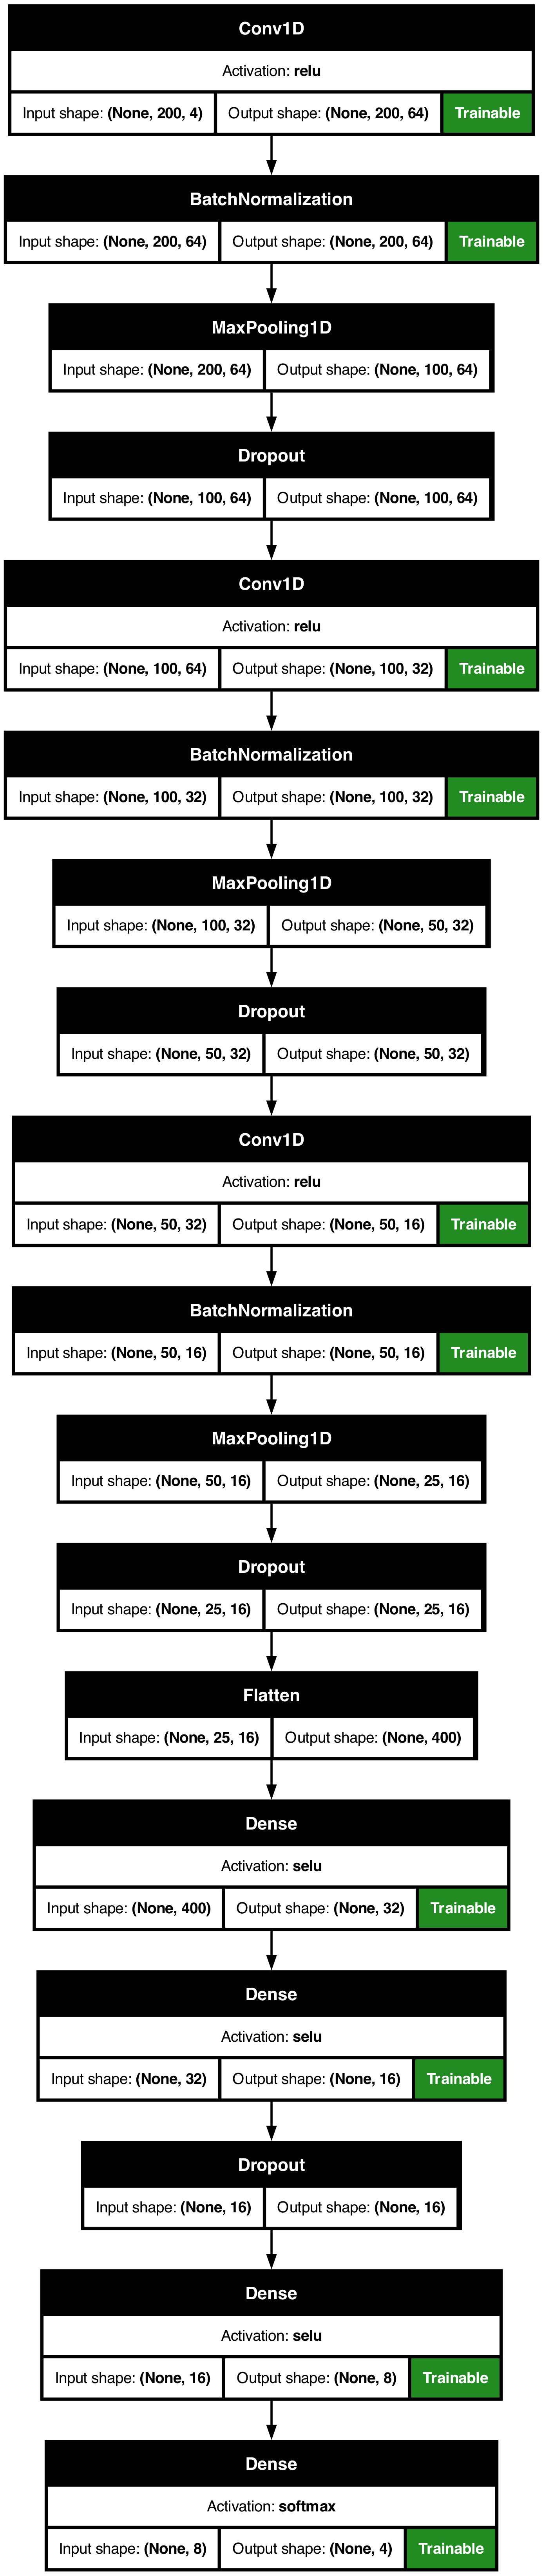

In [24]:
# modeling

from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from keras.models import Sequential

'''
    앞으로 모든 실험에서 classification은 아래 함수를 이용하여 모델을 생성합니다.
'''
def model_classification (input_shape) :
    model = Sequential([
        Conv1D(64, kernel_size=2, input_shape=input_shape, padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling1D(2, padding='same'),
        Dropout(0.2), 

        Conv1D(32, kernel_size=2, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(2, padding='same'),
        Dropout(0.2), 

        Conv1D(16, kernel_size=2, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(2, padding='same'),
        Dropout(0.2), 

        Flatten(),
        Dense(32, activation='selu'),
        Dense(16, activation='selu'),
        Dropout(0.1),
        Dense(8, activation='selu'),
        Dense(4, activation='softmax') # 다중 분류
    ])
    
    return model

model = model_classification(input_shape=(200, 4)) # input_shape은 여기서 (window에서의 records 수, feature의 갯수)

model.summary()

tf.keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True, show_trainable=True)


In [ ]:
# compile and fit, visualization loss

print("unique labels in y_train_seq:", np.unique(y_train_seq))

model.compile (metrics=['accuracy'], loss='sparse_categorical_crossentropy') # one-hot encoding을 하지 않아 sparse categorical crossentropy를 사용함
history = model.fit (X_train_seq, y_train_seq, epochs=30, 
                     verbose=True, validation_data=[X_val_seq, y_val_seq])

print (history)
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title("visualization loss and validation loss")
plt.legend()
plt.show()

unique labels in y_train_seq: [0 1 2 3]
Epoch 1/30
194/194 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.2997 - loss: 1.7894 - val_accuracy: 0.5211 - val_loss: 0.9453
Epoch 2/30
194/194 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.5250 - loss: 0.9654 - val_accuracy: 0.7466 - val_loss: 0.6117
Epoch 3/30
194/194 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.7024 - loss: 0.6541 - val_accuracy: 0.8672 - val_loss: 0.4045
Epoch 4/30
194/194 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.8037 - loss: 0.4638 - val_accuracy: 0.9136 - val_loss: 0.2823
Epoch 5/30
194/194 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.8534 - loss: 0.3605 - val_accuracy: 0.9215 - val_loss: 0.2257
Epoch 6/30
194/194 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.8910 - loss: 0.3033 - val_accuracy: 0.9329 - val_loss: 0.2083
Epoch 7/30
194/194 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.9039 - loss: 0.2611 - val_accuracy: 0.9458 - val_loss: 0.1797
Epoch 8/30
194/194 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - a

In [ ]:
# classification report and confusion matrix

from sklearn.metrics import confusion_matrix, classification_report

y_test_pred = model.predict(X_test_seq)

y_test_pred_classes = np.argmax(y_test_pred, axis=1)

############

cm_test = confusion_matrix(y_test_seq, y_test_pred_classes)
print ("- test data confusion matrix -\n")
print (cm_test)

print ('\n --------------- \n')

cr_test = classification_report(y_test_seq, y_test_pred_classes)
print ("- test data report of classification -\n")
print (cr_test)

print ('\n --------------- \n')